<a href="https://colab.research.google.com/github/lucas-fpaiva/tcc_pes/blob/main/preprocessing/final_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendendo o problema de predição de saude da aeronave

Objetivos:

* Separar duas aeronaves para o teste final 
* Selecionar duas das séries para analisar dentro das aeronaves de treino
* Visualizar e realizar o preprocessamento dos dados
* Aplicar um modelo de predição usando uma para treinar e outra para testar

In [2]:
print("Estou rodando no Colab (S/N)?")
ambiente = input()
ambiente=ambiente.upper()

if ambiente == "S":
  from google.colab import drive
  import os

  drive.mount('/content/drive',force_remount=True)
  os.chdir('/content/drive/Shareddrives/TCC_PES/codigos')

Estou rodando no Colab (S/N)?
s
Mounted at /content/drive


## Tratamento e organização inicial dos dados

In [3]:
#bibliotecas de manipulação de dados
import pandas as pd
import numpy as np

#visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as py
import matplotlib.gridspec as gridspec
from ast import literal_eval

#pré processamento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#modelos recorrentes Keras
from tensorflow.keras.layers import SimpleRNN as RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping

#bibliotecas necessárias para gridsearch
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#modelo sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

#métricas de avaliação dos modelos.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

#biblioteca Tensorflow
from tensorflow.keras.utils import set_random_seed 

### Tratamento inicial dos dados
* Mediana dos dias 
* Unificação dos datasets 
* Separação treino e teste final

In [4]:
def get_data(data_type):
  if data_type == "Train":
    #importando direto do github
    data_health = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/saude.csv')
  else:
    #importando direto do github
    data_health = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/saude_test.csv')

  #calculando a mediana dos dados
  data_health = data_health.groupby(by=['COD_FALH','COD_AENV','DT_PROC']).median().reset_index()
  return data_health

## Separação das amostras

In [5]:
#aplica filtro de média móvel
def serie_breaks (desgaste,fail):
  if fail ==35:
    dist =20
  else:
    dist =3
  quebras = []
  for i in range(0,len(desgaste)-1):
    if abs(desgaste[i]-desgaste[i+1])>dist:
      quebras.append(i)
  quebras = np.array(quebras)

  return quebras


#Transforma o banco de dados em instâncias/amostras de acordo com o janela de tempo utilizada
def get_samples (data, fail, look_back):
  samples=[]
  samples_day=[]
  n = look_back+10 #Tamanho (Dias) necessário da amostra

  for aircraft in np.unique(data.COD_AENV):
      air_data = data[(data.COD_AENV==aircraft)  & (data.COD_FALH==fail)] #filtrando por aeronave e fail
      degradation = air_data.VLR_DESG.values
      day = air_data.DT_PROC.values
      discontinuities = serie_breaks(degradation,fail) #identificando as descontinuidades
      discontinuities=np.append(discontinuities, len(degradation)-1) #insere o fim do trecho
      init=0
      for i in range(0,len(discontinuities)): 
        interval_break=degradation[init:discontinuities[i]+1] #intervalo entre duas quebras
        interval_days = day[init:discontinuities[i]+1] #dias correspondentes ao intervalo 
        init=discontinuities[i]+1
        if len(interval_break)>=look_back+10: #verifica se os intervalos possuem a quantidade minima de valores
            for i in range(0,len(interval_break)-n+1): #separa os intervalos em amostras
              sample = interval_break[i:i+n].tolist() #uma amostra com n valores
              sample_day = interval_days[i:i+n].tolist() #dias correspondentes à amostra
              sample_day.append(aircraft)
              sample.append(aircraft)
              samples.append(sample)
              samples_day.append(sample_day)
      
  samples = np.array(samples)
  samples_day = np.array(samples_day)
  return  samples, samples_day 


#Normalização das amostras
def normalize_samples(samples, norm_method):
  if norm_method=="MM(-1,1)":
    scaler = MinMaxScaler(feature_range=(-1, 1))
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  elif norm_method=="MM(0,1)":
    scaler = MinMaxScaler(feature_range=(0, 1))
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  elif norm_method=="Zscore":
    scaler = StandardScaler()
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  else:
    return samples


#Separa as amostras em em X,Y e treino, teste
def split_train_test (samples, air_test, look_back, norm_method=False, reshape=True): 
  data_train = samples[samples[:, look_back+10] != air_test][:, 0:look_back+10] #dados de treino
  #seperação de x e y
  x_train = data_train[:,0:look_back]
  y_train = data_train[:,look_back+9]

  if air_test==False:
    if norm_method != False:
      x_train, x_scaler = normalize_samples(x_train, norm_method)
      y_train, y_scaler = normalize_samples(y_train.reshape(-1, 1), norm_method)

      if reshape==True:
        x_train = np.reshape(x_train, (x_train.shape[0],1, x_train[0].shape[0])) 
        y_train = np.reshape(y_train, (y_train.shape[0],1, 1))
        return x_train, y_train, y_scaler, x_scaler

      else:
        return x_train, y_train, y_scaler, x_scaler
  
    return x_train, y_train

  data_test = samples[samples[:, look_back+10] == air_test][:, 0:look_back+10] #dados de teste
  #seperação de x e y
  x_test = data_test[:,0:look_back]
  y_test = data_test[:,look_back+9]

  #normalização de x e y
  x_train, x_scaler = normalize_samples(x_train, norm_method)
  x_test = x_scaler.transform(x_test)
  y_train, y_scaler = normalize_samples(y_train.reshape(-1, 1), norm_method)
  y_test = y_scaler.transform(y_test.reshape(-1, 1))

  #reshape para treinar os modelos recorrentes
  if reshape==True:
      x_train = np.reshape(x_train, (x_train.shape[0],1, x_train[0].shape[0])) 
      y_train = np.reshape(y_train, (y_train.shape[0],1, 1))
      x_test  = np.reshape(x_test , (x_test.shape[0], 1, x_test[0].shape[0]))
      y_test = np.reshape(y_test, (y_test.shape[0], 1,1))

  #retorna os scalers para reverter a normalização
  return x_train, y_train, x_test, y_test, y_scaler, x_scaler 


### Funções implementadas

In [22]:
#Retorna todas as métricas calculadas
def metrics(y_true,y_pred):
  rmse = mean_squared_error(y_true, y_pred, squared = False)
  max_e = max_error(y_true, y_pred) 
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  return([rmse, max_e, mae, r2])

In [7]:
#parâmetros a serem passado para o GridSearch
grid={'MLP':{
        'mlpregressor__random_state': [0],
        'mlpregressor__activation': ['tanh','relu'],
        'mlpregressor__solver' : ["adam"],
        'mlpregressor__hidden_layer_sizes': [5, 10, 25, 30, (2,2), (108,108,54), (162,162,108)],
        'mlpregressor__learning_rate_init': [0.001, 0.01 , 0.2],
        'mlpregressor__batch_size': [30],
        'mlpregressor__early_stopping': [True],
        'mlpregressor__n_iter_no_change': [5],
        'mlpregressor__validation_fraction': [0.2],
        'mlpregressor__max_iter': [500]},
      
      'SVR':{
        'svr__kernel': ['rbf', 'linear'], #default: rbf 
        # 'svr__gamma': [0.1, 10, 1000, 100000],
        'svr__epsilon': [0.001, 0.1],
        'svr__C': [0.4, 4, 40, 400, 4000]}, #[0.001, 0.01, 0.1, 1, 10]
      
      'LR':{
        'linearregression__n_jobs': [-1]}}

In [75]:
set_random_seed(123)

def fail_model(fail):
  if fail == 1:
    model_name = "CLR"
    norm = "Zscore"
    look_back = 10
    model = LinearRegression(n_jobs = -1)

  elif fail == 23:
    model_name = "SRNN"
    norm = "Zscore"
    look_back = 30
    model = Sequential()
    model.add(RNN(256, input_shape=(1, look_back)))
    model.add(Dense(56, kernel_regularizer='l2'))
    model.add(Dropout(0))
    model.add(Dense(1, kernel_regularizer='l2'))

  elif fail == 24:
    model_name = "SLSTM"
    norm = "Zscore"
    look_back = 30
    model = Sequential()
    model.add(RNN(256, input_shape=(1, look_back)))
    model.add(Dense(56, kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_regularizer='l2'))

  elif fail == 35:
    model_name = "DRNN"
    norm = "MM(-1,1)"
    look_back = 10
    model = Sequential()
    model.add(RNN(14, input_shape=(1, look_back), return_sequences = True))
    model.add(RNN(21, return_sequences = True))
    model.add(RNN(14))
    model.add(Dropout(0))
    model.add(Dense(1)) 

  return model, look_back, norm, model_name

# Tratamento e separação x, y
def final_split (data, data_test, fail, model_name, look_back, norm):
  
  samples,_ = get_samples (data,fail=fail, look_back= look_back)
  samples_test, test_days = get_samples (data_test,fail=fail, look_back= look_back)
  x_test, y_test = split_train_test(samples_test, air_test=False, look_back=look_back, norm_method = False, reshape=False)

  if model_name[0] == "C":
    reshape=False
  else: 
    reshape=True
  
  x_train, y_train, y_scaler, x_scaler = split_train_test(samples,air_test=False, look_back=look_back, norm_method = norm, reshape=reshape)
  
  x_test =  x_scaler.transform(x_test)
  
  if reshape == True:
    x_test  = np.reshape(x_test, (x_test.shape[0], 1, x_test[0].shape[0]))

  return x_train, y_train, x_test, y_test, y_scaler, samples_test, test_days

def retrain_model(data, data_test, fail):
  results = []
  model, look_back, norm, model_name = fail_model(fail)

  x_train, y_train, x_test, y_test, y_scaler, samples_test, test_days = final_split (data, data_test, fail, model_name, look_back, norm)

  if model_name[0] != "C":
    early_stopping = EarlyStopping(patience=5)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=400, batch_size=170, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    #revertendo a normalização e realizando a predição
    y_pred_rev = y_scaler.inverse_transform(model.predict(x_test)[:,0].reshape(-1,1))
  else:
    model.fit(x_train, y_train.ravel())
    #revertendo a normalização e realizando a predição
    y_pred_rev = y_scaler.inverse_transform(model.predict(x_test).reshape(-1,1))
    
  return y_pred_rev, y_test, test_days,look_back

16/16 [==============================] - 0s 2ms/step


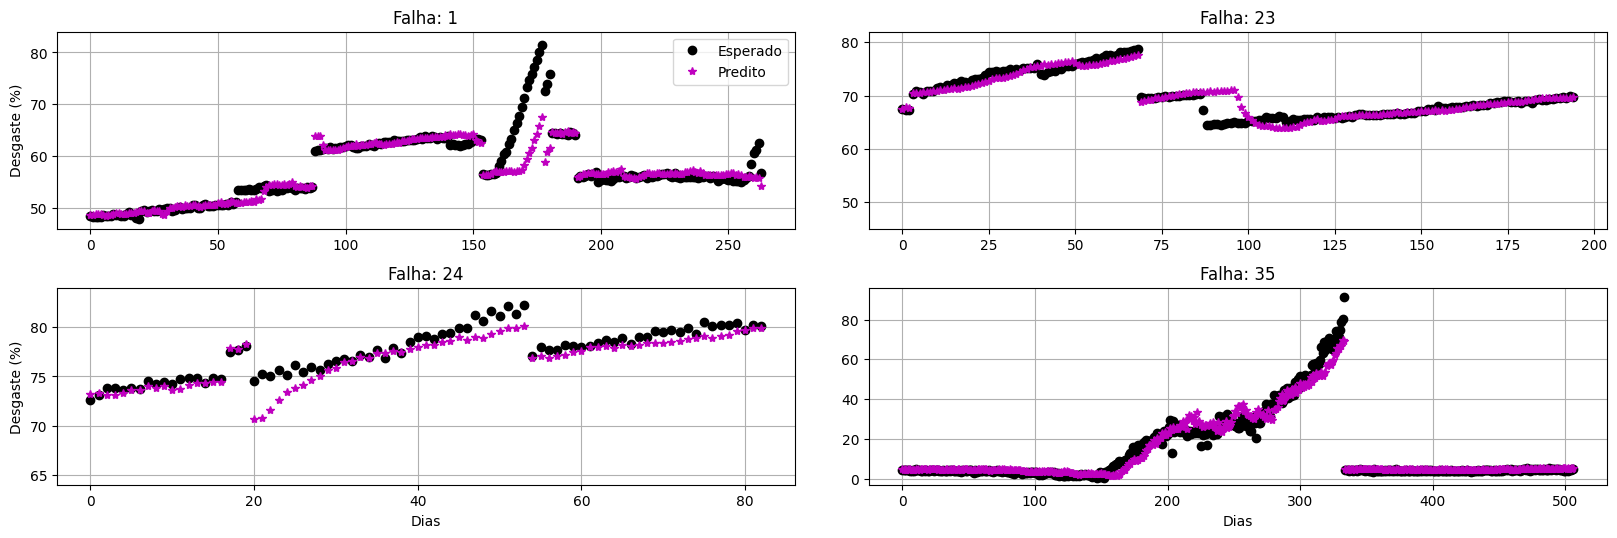

In [49]:
data = get_data("Train")
data_test = get_data("Test")

results = []
fig = plt.figure(figsize = (20,6),dpi=100)
axes = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, wspace=0.1, hspace=0.3)
count= 0
im = [ [0,0], [0,1], [1,0], [1,1] ]
for fail in [1,23,24,35]:
  y_pred_rev, y_test, test_days, look_back = retrain_model(data, data_test, fail)
  
  result = metrics(y_test,y_pred_rev)
  result.append(fail)
  results.append(result)

  # i,s = 46,84 #Falha 1
  # i,s = 45,82 #Falha 23
  # i,s = 64,84 #Falha 24
  # i,s = -3,96#Falha 35
  i = [46,45,64,-3]
  s = [84,82,84,96]

  
  #plot do melhor modelo
  ax = fig.add_subplot(axes[im[count][0], im[count][1]])
  ax.grid()
  ax.set_title("Falha: "+ str(fail))
  # ax.text(-0.065, -0.17, im[0], size=20, weight='bold', transform=ax.transAxes)
  ax.plot(y_test,'ok')
  ax.plot(y_pred_rev,'*m')
  # ax.set_ylim([-1,70])
  if count == 2 or count == 3:
    ax.set_xlabel("Dias")
  if count == 0 or count == 2:
    ax.set_ylabel("Desgaste (%)")
  if count==0:
    ax.legend(["Esperado",'Predito'])
  ax.set_ylim(i[count],s[count])
  count+=1
plt.savefig('resultados/fig_final_predict.pdf', format="pdf", dpi=1000, bbox_inches="tight")
#cria o dataframe com os resultados
data_results = pd.DataFrame(results, columns= ['RMSE', 'MaxE', 'MAE', "R2",'Falha'])

16/16 [==============================] - 0s 2ms/step


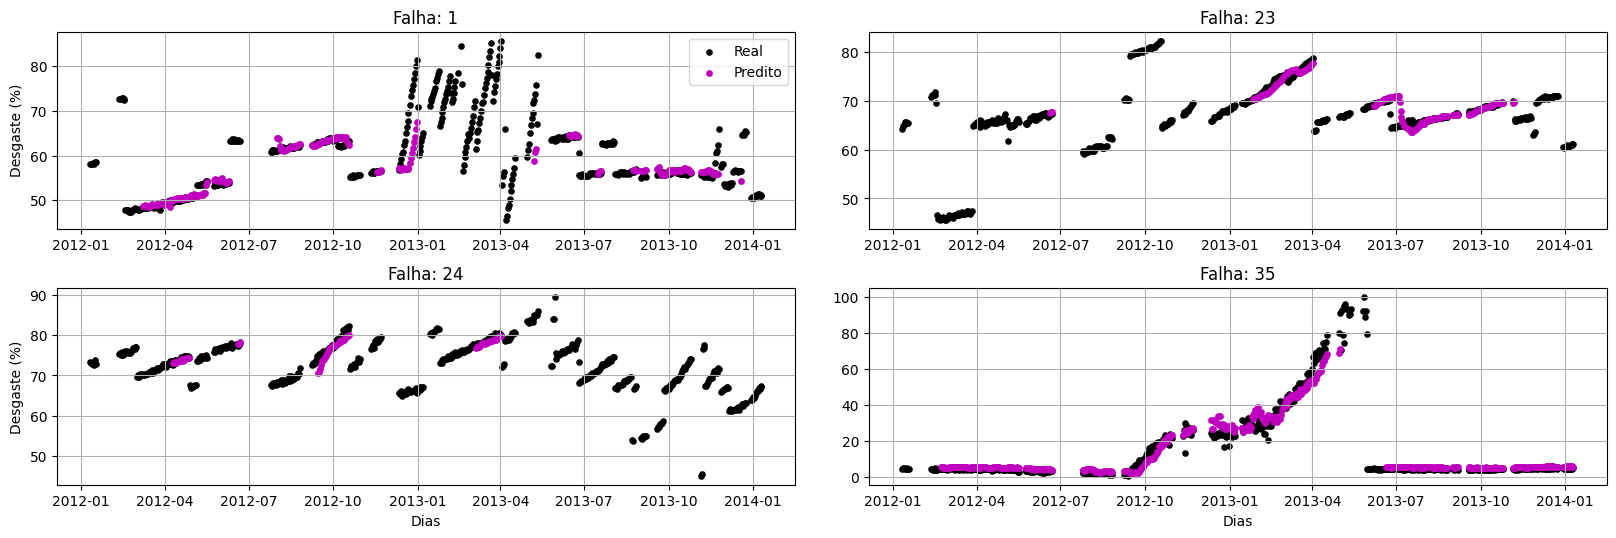

In [90]:
results = []
fig = plt.figure(figsize = (20,6),dpi=100)
axes = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, wspace=0.1, hspace=0.3)

count= 0
im = [ [0,0], [0,1], [1,0], [1,1] ]

for fail in [1,23,24,35]:

  y_pred_rev, y_test, test_days, look_back = retrain_model(data, data_test, fail)
  days = np.array(test_days[:,look_back+9],dtype= 'datetime64')
  df_all = data_test[data_test.COD_FALH == fail]
  
  result = metrics(y_test,y_pred_rev)
  result.append(fail)
  results.append(result)

  #PLOT
  ax = fig.add_subplot(axes[im[count][0], im[count][1]])
  ax.grid()
  ax.set_title("Falha: "+ str(fail))
  ax.scatter(pd.to_datetime(df_all['DT_PROC']), df_all['VLR_DESG'], color='black', marker="o", s=14)
  # ax.scatter(days, y_test, color='black' , marker="o")
  ax.scatter(days, y_pred_rev, color='m' , marker="o",s=15 )
  
  ax.grid(True)
  if count == 2 or count == 3:
    ax.set_xlabel("Dias")
  if count == 0 or count == 2:
    ax.set_ylabel("Desgaste (%)")
  if count==0:
    ax.legend(['Real', 'Predito'])
  count+=1

plt.savefig('resultados/fig_final_predict.pdf', format="pdf", dpi=1000, bbox_inches="tight")
#cria o dataframe com os resultados
data_results = pd.DataFrame(results, columns= ['RMSE', 'MaxE', 'MAE', "R2",'Falha'])


In [54]:
print(round(data_results,3).to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 RMSE &   MaxE &   MAE &    R2 &  Falha \\
\midrule
3.331 & 14.339 & 1.448 & 0.729 &      1 \\
1.591 &  6.423 & 0.883 & 0.837 &     23 \\
1.243 &  4.524 & 0.904 & 0.733 &     24 \\
3.583 & 21.727 & 2.126 & 0.957 &     35 \\
\bottomrule
\end{tabular}



#Visualização dos resultados

In [ ]:
#Paleta de cores do BarPlot
colors1 = [    
          (15/255,114/255,255/255,1), # blue 
          (224/255,0/255,193/255,.88), #pink
          (1.0, 0.807843137254902, 0.0392156862745098, 1), #orange
          (0.95, 0, 0, 1), #red
          (0, 0.6666666666666666, 0.6274509803921569, 1), #green
          
          (0, 0.9764705882352941, 0, 0.5), #       
          (10/255,10/255, 130/255, 1), #(0.4, 0.0, 0.6, 1), # green
          (0.6, 0/255, 0.4, 0.8)#
        ]

#Importação e BarPlot dos melhores modelos
import matplotlib.patches as mpatches
sns.set_theme(style="white", palette=None)
fig = plt.figure(figsize = (20,5),dpi=100)
axes = gridspec.GridSpec(nrows=1, ncols=3, figure=fig, wspace=0.2, hspace=0.3)

# im = ['a','b','c']
count=0

for model_type in ["classical", "shallow", "deep"]:
  best_models = get_best_models(model_type, fail)
  best_models['Combinação'] = best_models ["Normalização"] +'+'+ best_models ["Modelo"]

  ax = fig.add_subplot(axes[count])
  ax.grid()
  
  sns.boxplot(data = best_models, y='RMSE',x='Janela',hue='Modelo', palette = colors1,
              showmeans=True,meanprops={"marker":".", "markerfacecolor":"black", 
                        "markeredgecolor":"black", "markersize":"10"})
  # ax.text(-0.05, -0.1, im[count], size=20, weight='bold', transform=ax.transAxes)
  if model_type == "shallow":
    ax.set_title("Shallow")
    labels = ['SLSTM', 'SGRU', 'SRNN']
  elif model_type == "deep":
    ax.set_title("Deep")
    labels = ['DLSTM', 'DGRU', 'DRNN']
  else: 
    ax.set_title("Clássico")
    labels = ['MLP', 'SVM', 'LR']

  pop_a = mpatches.Patch(facecolor=colors1[0], label=labels[0], edgecolor='gray')
  pop_b = mpatches.Patch(facecolor=colors1[1], label=labels[1], edgecolor='gray')
  pop_c = mpatches.Patch(facecolor=colors1[2], label=labels[2], edgecolor='gray')
  plt.legend(handles=[pop_a,pop_b,pop_c], loc='upper left', ncol=1)
  
  # ax.set_ylim(0.1,5.3) #Falha 01
  # ax.set_ylim(0.5,5.5) #Falha 23
  # ax.set_ylim(0.6,2.5) #Falha 24
  # ax.set_ylim(2.5,9)   #Falha 35
  
  count+=1
# plt.savefig('resultados/fig_results_grid_f'+str(fail)+'.pdf', format="pdf", dpi=1000, bbox_inches="tight")

In [11]:
px.line(data_test, x='DT_PROC', y='VLR_DESG', color='COD_AENV', line_dash='COD_FALH')